In [1]:
import os
import time
import numpy as np
import wurlitzer

import infer
import infer_test_utils as utils

# this allows us to capture stdout and stderr from the backend c++ infer-runtime
display_output = wurlitzer.sys_pipes

In [2]:
inputs = utils.load_inputs("/work/models/onnx/mnist-v1.3/test_data_set_0")
expected = utils.load_outputs("/work/models/onnx/mnist-v1.3/test_data_set_0")

In [3]:
!trtexec --onnx=/work/models/onnx/mnist-v1.3/model.onnx --saveEngine=/tmp/mnist-v1.3.engine

&&&& RUNNING TensorRT.trtexec # trtexec --onnx=/work/models/onnx/mnist-v1.3/model.onnx --saveEngine=/tmp/mnist-v1.3.engine
[I] onnx: /work/models/onnx/mnist-v1.3/model.onnx
[I] saveEngine: /tmp/mnist-v1.3.engine
----------------------------------------------------------------
Input filename:   /work/models/onnx/mnist-v1.3/model.onnx
ONNX IR version:  0.0.3
Opset version:    8
Producer name:    CNTK
Producer version: 2.5.1
Domain:           ai.cntk
Model version:    1
Doc string:       
----------------------------------------------------------------
[I] [TRT] Detected 1 input and 1 output network tensors.
[I] Engine has been successfully saved to /tmp/mnist-v1.3.engine
[I] name= Input3, bindingIndex=0, buffers.size()=2
[I] name= Plus214_Output_0, bindingIndex=1, buffers.size()=2
[I] Average over 10 runs is 0.067584 ms (host walltime is 0.109844 ms, 99% percentile time is 0.098304).
[I] Average over 10 runs is 0.0636928 ms (host walltime is 0.108193 ms, 99% percentile time is 0.067584).

# Local Inference Setup

In [4]:
with display_output():
    manager = infer.InferenceManager(max_exec_concurrency=2)

I0118 05:22:18.616114  1064 inference_manager.cc:64] -- Initialzing TensorRT Resource Manager --
I0118 05:22:18.616134  1064 inference_manager.cc:65] Maximum Execution Concurrency: 2
I0118 05:22:18.616138  1064 inference_manager.cc:66] Maximum Copy Concurrency: 4


In [5]:
with display_output():
    manager.register_tensorrt_engine("mnist", "/tmp/mnist-v1.3.engine")

I0118 05:22:21.617839  1064 model.cc:91] Binding: Input3; isInput: true; dtype size: 4; bytes per batch item: 3136
I0118 05:22:21.617864  1064 model.cc:91] Binding: Plus214_Output_0; isInput: false; dtype size: 4; bytes per batch item: 40
I0118 05:22:21.618674  1064 inference_manager.cc:149] -- Registering Model: mnist --
I0118 05:22:21.618687  1064 inference_manager.cc:150] Input/Output Tensors require 3.1 KiB
I0118 05:22:21.618692  1064 inference_manager.cc:151] Execution Activations require 55.5 KiB
I0118 05:22:21.618696  1064 inference_manager.cc:155] Weights require 23.6 KiB


In [6]:
with display_output():
    manager.update_resources()

I0118 05:22:22.524006  1064 inference_manager.cc:194] -- Allocating TensorRT Resources --
I0118 05:22:22.524017  1064 inference_manager.cc:195] Creating 2 TensorRT execution tokens.
I0118 05:22:22.524021  1064 inference_manager.cc:196] Creating a Pool of 4 Host/Device Memory Stacks
I0118 05:22:22.524027  1064 inference_manager.cc:197] Each Host Stack contains 32.0 KiB
I0118 05:22:22.524031  1064 inference_manager.cc:198] Each Device Stack contains 128.0 KiB
I0118 05:22:22.524035  1064 inference_manager.cc:199] Total GPU Memory: 768.0 KiB


# Local Inference Properties

In [7]:
mnist = manager.infer_runner("mnist")

In [8]:
mnist.input_bindings()

{'Input3': {'dtype': dtype('float32'), 'shape': [1, 28, 28]}}

In [9]:
mnist.output_bindings()

{'Plus214_Output_0': {'dtype': dtype('float32'), 'shape': [10]}}

# Local Inference Compute

In [10]:
futures = [mnist.infer(Input3=input) for input in inputs]

In [11]:
# free to do other work while inference is being computed

In [12]:
results = [f.get() for f in futures]

Test Passed
Result: 2


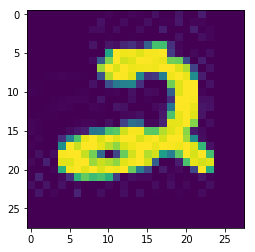

array([[  975.6701  ,  -618.72394 ,  6574.5684  ,   668.02893 ,
         -917.27094 , -1671.6359  , -1952.7599  ,   -61.549873,
         -777.17664 , -1439.5316  ]], dtype=float32)

In [13]:
for r, e in zip(results, expected):
    for key, val in r.items():
        r = val.reshape((1,10))
        np.testing.assert_almost_equal(r, e, decimal=3)
        print("Test Passed")
        print("Result: {}".format(np.argmax(utils.softmax(r))))

utils.mnist_image(inputs[0]).show()
expected[0]